# Text Embedding Visualization with Gemini text-embedding-004

This notebook demonstrates how to:
1. Generate text embeddings using Google's Gemini text-embedding-004 model
2. Reduce the dimensionality of these embeddings using PCA
3. Visualize the compressed embeddings in 2D space

## 1. Setup and Dependencies

In [40]:
# Install required packages
!pip install google-generativeai pandas numpy matplotlib scikit-learn seaborn


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [41]:
# Import necessary libraries
import google.generativeai as genai
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import os
from matplotlib.colors import ListedColormap
import seaborn as sns

## 2. Set up Google API Access

In [42]:
# Set your Google API key
# You can set it as an environment variable or directly
# Option 1: Environment variable
# os.environ['GOOGLE_API_KEY'] = 'your-api-key-here'

# Option 2: Direct configuration
GOOGLE_API_KEY = "your-api-key"  # Replace with your actual API key
genai.configure(api_key=GOOGLE_API_KEY)

## 3. Create Sample Text Data

We'll create sample text data grouped into different categories to visualize how embeddings cluster.

In [43]:
# Create sample text data with different categories
texts = [
    # Technology category
    "Artificial intelligence is transforming how we interact with computers.",
    "Machine learning algorithms improve with more data and training.",
    "Neural networks are inspired by the human brain's structure.",
    "Cloud computing provides scalable infrastructure for businesses.",
    "Blockchain technology enables secure decentralized transactions.",
    
    # Nature category
    "The Amazon rainforest is home to millions of plant and animal species.",
    "Coral reefs support a diverse ecosystem of marine life.",
    "Redwood trees can live for thousands of years and grow to immense heights.",
    "Monarch butterflies migrate thousands of miles each year.",
    "The Sahara desert experiences extreme temperature variations between day and night.",
    
    # Food category
    "Italian cuisine is known for its regional diversity and fresh ingredients.",
    "Sushi preparation requires years of training to master.",
    "Spices have been traded globally for centuries and shaped culinary traditions.",
    "Fermentation preserves food and creates complex flavors.",
    "Farm-to-table restaurants prioritize locally sourced ingredients."
]

# Create labels for each text (for coloring in visualization)
categories = ['Technology'] * 5 + ['Nature'] * 5 + ['Food'] * 5

# Create a DataFrame to store texts and their categories
df = pd.DataFrame({
    'text': texts,
    'category': categories
})

df.head()

,text,category
0,Artificial intelligence is transforming how we...,Technology
1,Machine learning algorithms improve with more ...,Technology
2,Neural networks are inspired by the human brai...,Technology
3,Cloud computing provides scalable infrastructu...,Technology
4,Blockchain technology enables secure decentral...,Technology


## 4. Generate Embeddings using Gemini text-embedding-004

In [44]:
# Set up the embedding model
embedding_model = 'models/text-embedding-004'

# Function to get embeddings for a given text
def get_embedding(text):
    embedding = genai.embed_content(
        model=embedding_model,
        content=text,
        task_type="retrieval_document",  # Can be adjusted based on your needs
    )
    return embedding['embedding']

# Generate embeddings for all texts
embeddings = []
for text in df['text']:
    embedding = get_embedding(text)
    embeddings.append(embedding)

# Convert embeddings to numpy array
embeddings_array = np.array(embeddings)

# Check the shape of embeddings
print(f"Embedding shape: {embeddings_array.shape}")

Embedding shape: (15, 768)


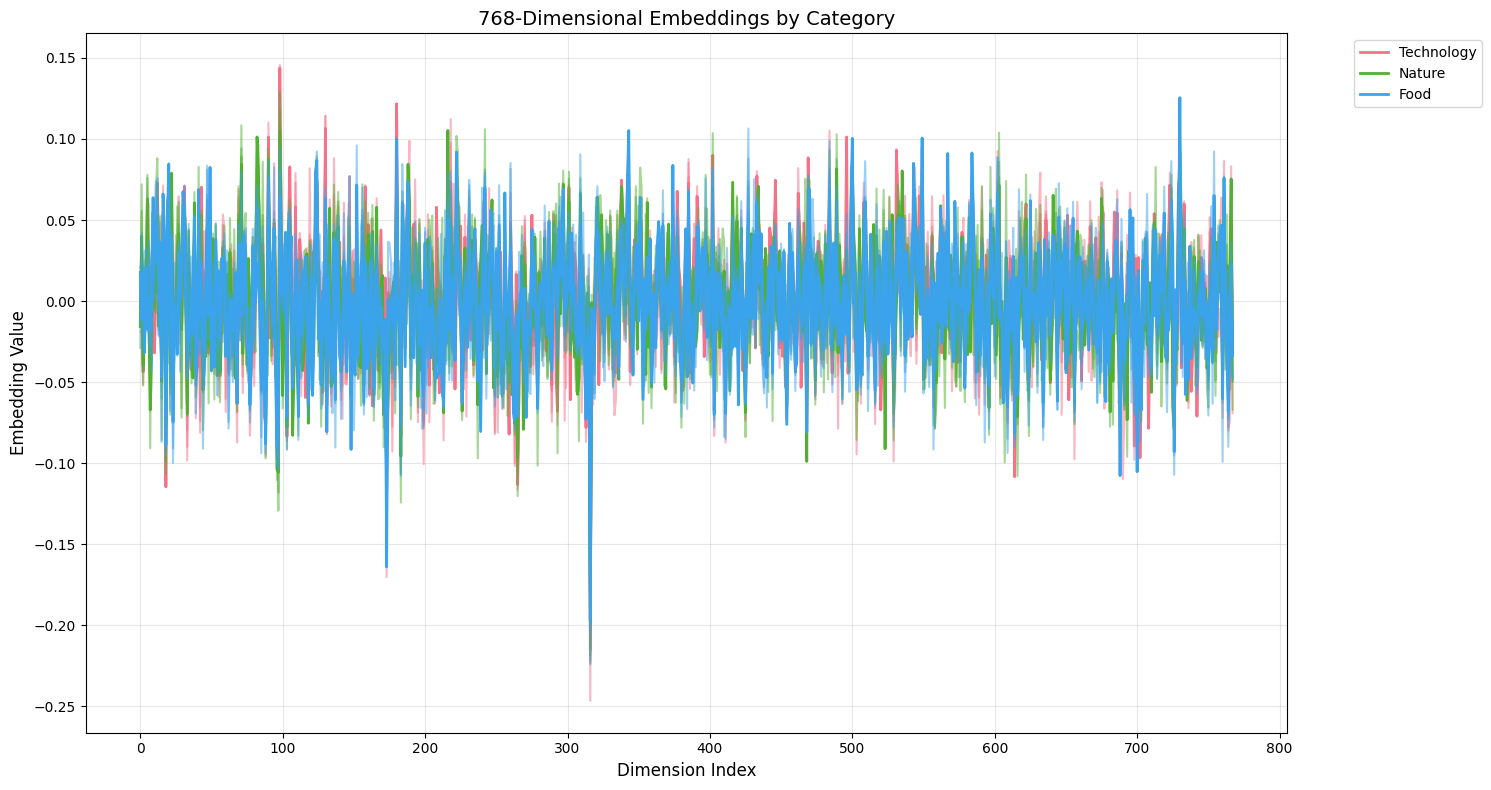

In [45]:
palette = sns.color_palette("husl", len(df["category"].unique()))
category_colors = {
    category: palette[i] for i, category in enumerate(df["category"].unique())
}

plt.figure(figsize=(15, 8))

# embeddings配列とテキストを紐付けて処理
for category in df['category'].unique():
    # そのカテゴリのインデックス番号を取得
    indices = df[df['category'] == category].index.values
    
    # インデックス番号を使ってembeddingsから該当するデータを抽出
    category_embeddings = np.array([embeddings[idx] for idx in indices])
    
    # カテゴリごとに同じ色で描画
    for emb in category_embeddings:
        plt.plot(range(768), emb, color=category_colors[category], alpha=0.5)
    
    # 凡例用に1本だけラベル付きでプロット
    plt.plot(range(768), category_embeddings[0], 
            color=category_colors[category], 
            label=category,
            linewidth=2)

plt.title("768-Dimensional Embeddings by Category", fontsize=14)
plt.xlabel("Dimension Index", fontsize=12)
plt.ylabel("Embedding Value", fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


## 5. Dimensionality Reduction using PCA

We'll use PCA to reduce the high-dimensional embeddings to 2 dimensions for visualization.

In [46]:
# Apply PCA to reduce embeddings to 2 dimensions
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings_array)

# Check the shape of reduced embeddings
print(f"Reduced embedding shape: {reduced_embeddings.shape}")

# Calculate the variance explained by the first two principal components
explained_variance = pca.explained_variance_ratio_
print(f"Variance explained by the first two principal components: {explained_variance}")
print(f"Total variance explained: {sum(explained_variance):.2%}")

Reduced embedding shape: (15, 2)
Variance explained by the first two principal components: [0.18918337 0.17272583]
Total variance explained: 36.19%


## 6. Visualize Embeddings in 2D Space

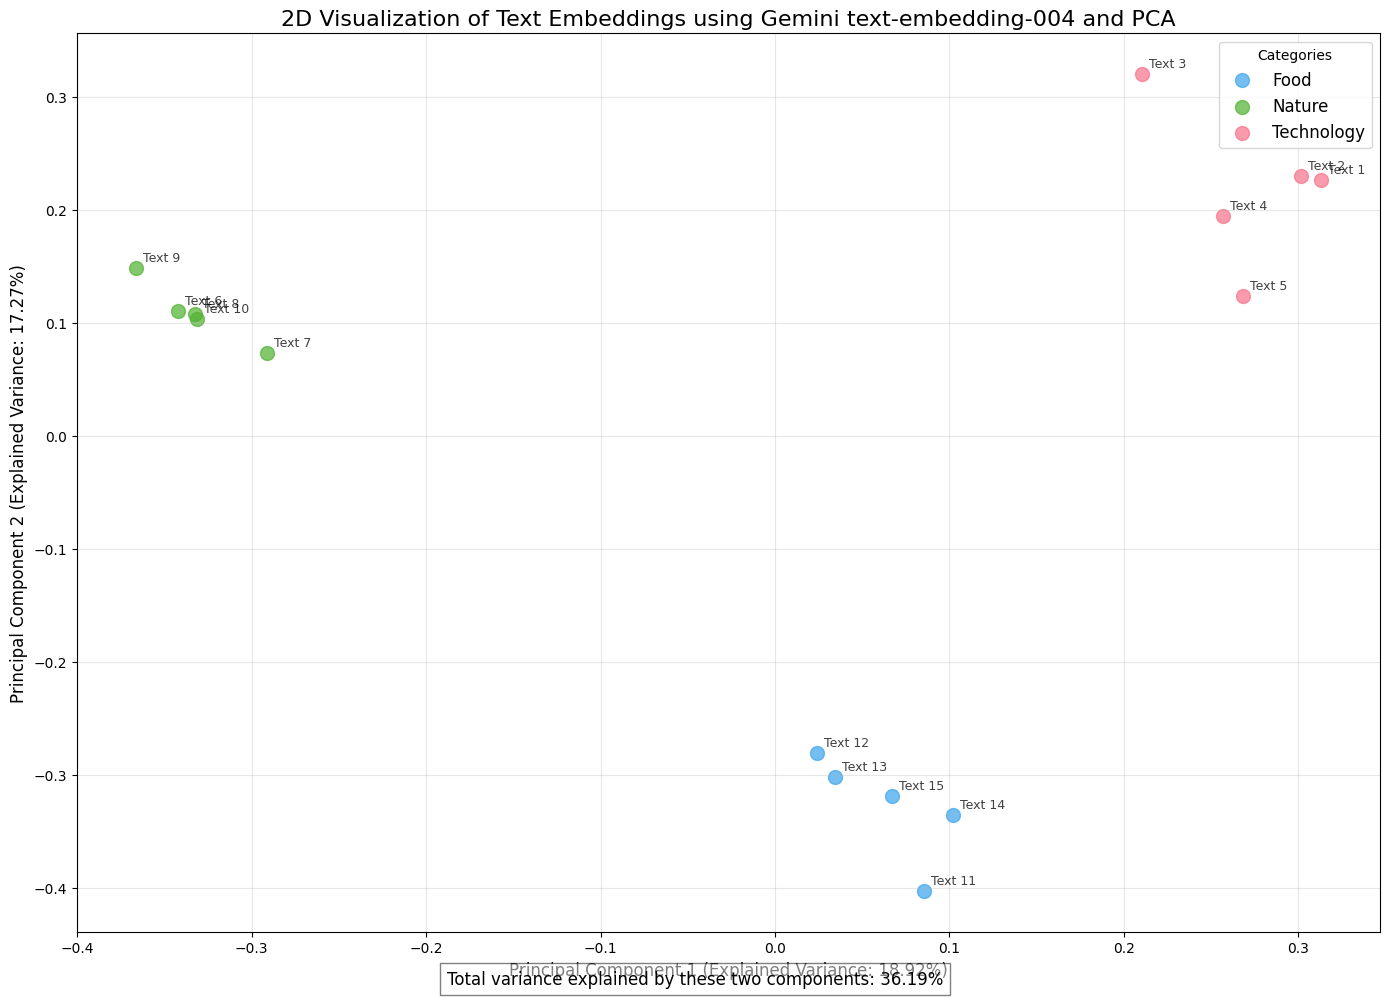

In [47]:
# Add reduced embeddings to the DataFrame
df["x"] = reduced_embeddings[:, 0]
df["y"] = reduced_embeddings[:, 1]

# Set up a color palette for categories
palette = sns.color_palette("husl", len(df["category"].unique()))
category_colors = {
    category: palette[i] for i, category in enumerate(df["category"].unique())
}

# Create a more sophisticated visualization
plt.figure(figsize=(14, 10))

# Plot each category with different colors
for category, group in df.groupby("category"):
    plt.scatter(
        group["x"],
        group["y"],
        label=category,
        color=category_colors[category],
        s=100,
        alpha=0.7,
    )

# Add labels for each point
for i, row in df.iterrows():
    plt.annotate(
        f"Text {i + 1}",
        (row["x"], row["y"]),
        fontsize=9,
        alpha=0.75,
        xytext=(5, 5),
        textcoords="offset points",
    )

# Add a title and labels with variance information
plt.title(
    "2D Visualization of Text Embeddings using Gemini text-embedding-004 and PCA",
    fontsize=16,
)
plt.xlabel(
    f"Principal Component 1 (Explained Variance: {explained_variance[0]:.2%})",
    fontsize=12,
)
plt.ylabel(
    f"Principal Component 2 (Explained Variance: {explained_variance[1]:.2%})",
    fontsize=12,
)

# Add a legend
plt.legend(fontsize=12, title="Categories")

# Add grid lines
plt.grid(alpha=0.3)

# Add a text box with the total explained variance
plt.figtext(
    0.5,
    0.01,
    f"Total variance explained by these two components: {sum(explained_variance):.2%}",
    ha="center",
    fontsize=12,
    bbox={"facecolor": "white", "alpha": 0.5, "pad": 5},
)

plt.tight_layout()
plt.show()

## 7. Additional Analysis: Display the Nearest Neighbors

In [48]:
# Function to compute cosine similarity between embeddings
def cosine_similarity(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))


# Let's find and display the nearest neighbor for each text
nearest_neighbors = []

for i, embedding in enumerate(embeddings):
    similarities = []
    for j, other_embedding in enumerate(embeddings):
        if i != j:  # Skip comparing with itself
            similarity = cosine_similarity(embedding, other_embedding)
            similarities.append((j, similarity))

    # Sort by similarity (highest first)
    similarities.sort(key=lambda x: x[1], reverse=True)

    # Get the most similar text
    most_similar_idx, similarity_score = similarities[0]

    nearest_neighbors.append(
        {
            "text": df.loc[i, "text"],
            "category": df.loc[i, "category"],
            "most_similar_text": df.loc[most_similar_idx, "text"],
            "most_similar_category": df.loc[most_similar_idx, "category"],
            "similarity_score": similarity_score,
        }
    )

# Create DataFrame for nearest neighbors
nn_df = pd.DataFrame(nearest_neighbors)
nn_df

,text,category,most_similar_text,most_similar_category,similarity_score
0,Artificial intelligence is transforming how we...,Technology,Machine learning algorithms improve with more ...,Technology,0.799438
1,Machine learning algorithms improve with more ...,Technology,Artificial intelligence is transforming how we...,Technology,0.799438
2,Neural networks are inspired by the human brai...,Technology,Artificial intelligence is transforming how we...,Technology,0.765810
3,Cloud computing provides scalable infrastructu...,Technology,Blockchain technology enables secure decentral...,Technology,0.788261
4,Blockchain technology enables secure decentral...,Technology,Cloud computing provides scalable infrastructu...,Technology,0.788261
5,The Amazon rainforest is home to millions of p...,Nature,Coral reefs support a diverse ecosystem of mar...,Nature,0.775915
6,Coral reefs support a diverse ecosystem of mar...,Nature,The Amazon rainforest is home to millions of p...,Nature,0.775915
7,Redwood trees can live for thousands of years ...,Nature,The Amazon rainforest is home to millions of p...,Nature,0.762001
8,Monarch butterflies migrate thousands of miles...,Nature,The Amazon rainforest is home to millions of p...,Nature,0.737155
9,The Sahara desert experiences extreme temperat...,Nature,The Amazon rainforest is home to millions of p...,Nature,0.672559


## 8. Advanced Visualization: 3D PCA

Variance explained by the first three principal components: [0.18918337 0.17272577 0.08032165]
Total variance explained: 44.22%


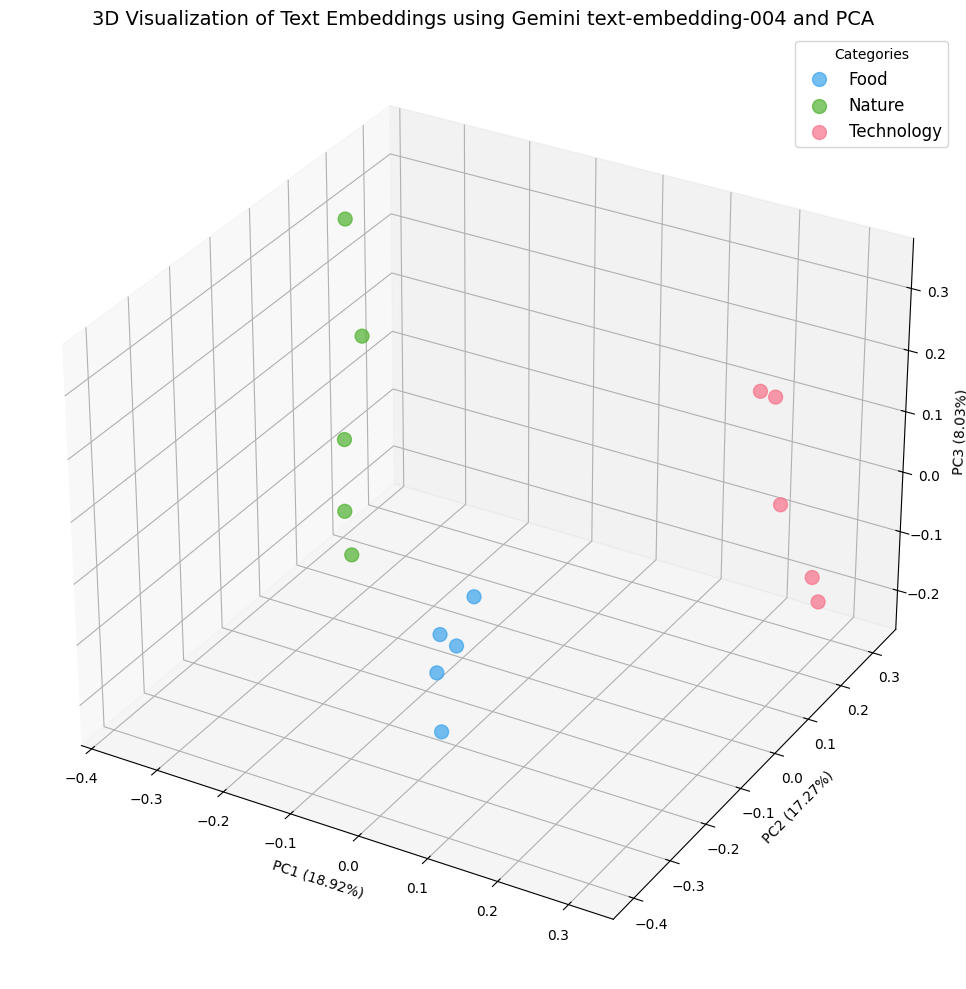

In [49]:
# For more insights, let's try 3D PCA
from mpl_toolkits.mplot3d import Axes3D

# Apply PCA to reduce embeddings to 3 dimensions
pca_3d = PCA(n_components=3)
reduced_embeddings_3d = pca_3d.fit_transform(embeddings_array)

# Calculate the variance explained by the first three principal components
explained_variance_3d = pca_3d.explained_variance_ratio_
print(
    f"Variance explained by the first three principal components: {explained_variance_3d}"
)
print(f"Total variance explained: {sum(explained_variance_3d):.2%}")

# Add reduced embeddings to the DataFrame
df["x_3d"] = reduced_embeddings_3d[:, 0]
df["y_3d"] = reduced_embeddings_3d[:, 1]
df["z_3d"] = reduced_embeddings_3d[:, 2]

# Create 3D visualization
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection="3d")

# Plot each category with different colors
for category, group in df.groupby("category"):
    ax.scatter(
        group["x_3d"],
        group["y_3d"],
        group["z_3d"],
        label=category,
        color=category_colors[category],
        s=100,
        alpha=0.7,
    )

# Add title and labels
ax.set_title(
    "3D Visualization of Text Embeddings using Gemini text-embedding-004 and PCA",
    fontsize=14,
)
ax.set_xlabel(f"PC1 ({explained_variance_3d[0]:.2%})", fontsize=10)
ax.set_ylabel(f"PC2 ({explained_variance_3d[1]:.2%})", fontsize=10)
ax.set_zlabel(f"PC3 ({explained_variance_3d[2]:.2%})", fontsize=10)

# Add a legend
ax.legend(fontsize=12, title="Categories")

plt.tight_layout()
plt.show()

## 9. Analysis and Insights

### Observations:
- The PCA visualization reveals how the Gemini text-embedding-004 model clusters semantically related texts
- Texts from the same category tend to be closer in the embedding space
- The first two principal components explain a significant portion of the variance
- Nearest neighbor analysis confirms the semantic relationships captured by the embeddings

### Potential Applications:
- Document classification
- Content recommendation systems
- Semantic search
- Topic modeling
- Text clustering

## 10. Bonus: t-SNE Visualization

PCA is a linear dimensionality reduction technique. For a different perspective, let's try t-SNE, which can better preserve local relationships in the embedding space.

  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used by one of your dependencies,
        it would be great if you take some time to track which package uses
        'sklearn' instead of 'scikit-learn' and report it to their issue tracker
      - as a last resort, set the environment variable
        SKLEARN_ALLOW_DEPRECATED_SK

/home/fleagne/.pyenv/versions/3.12.7/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


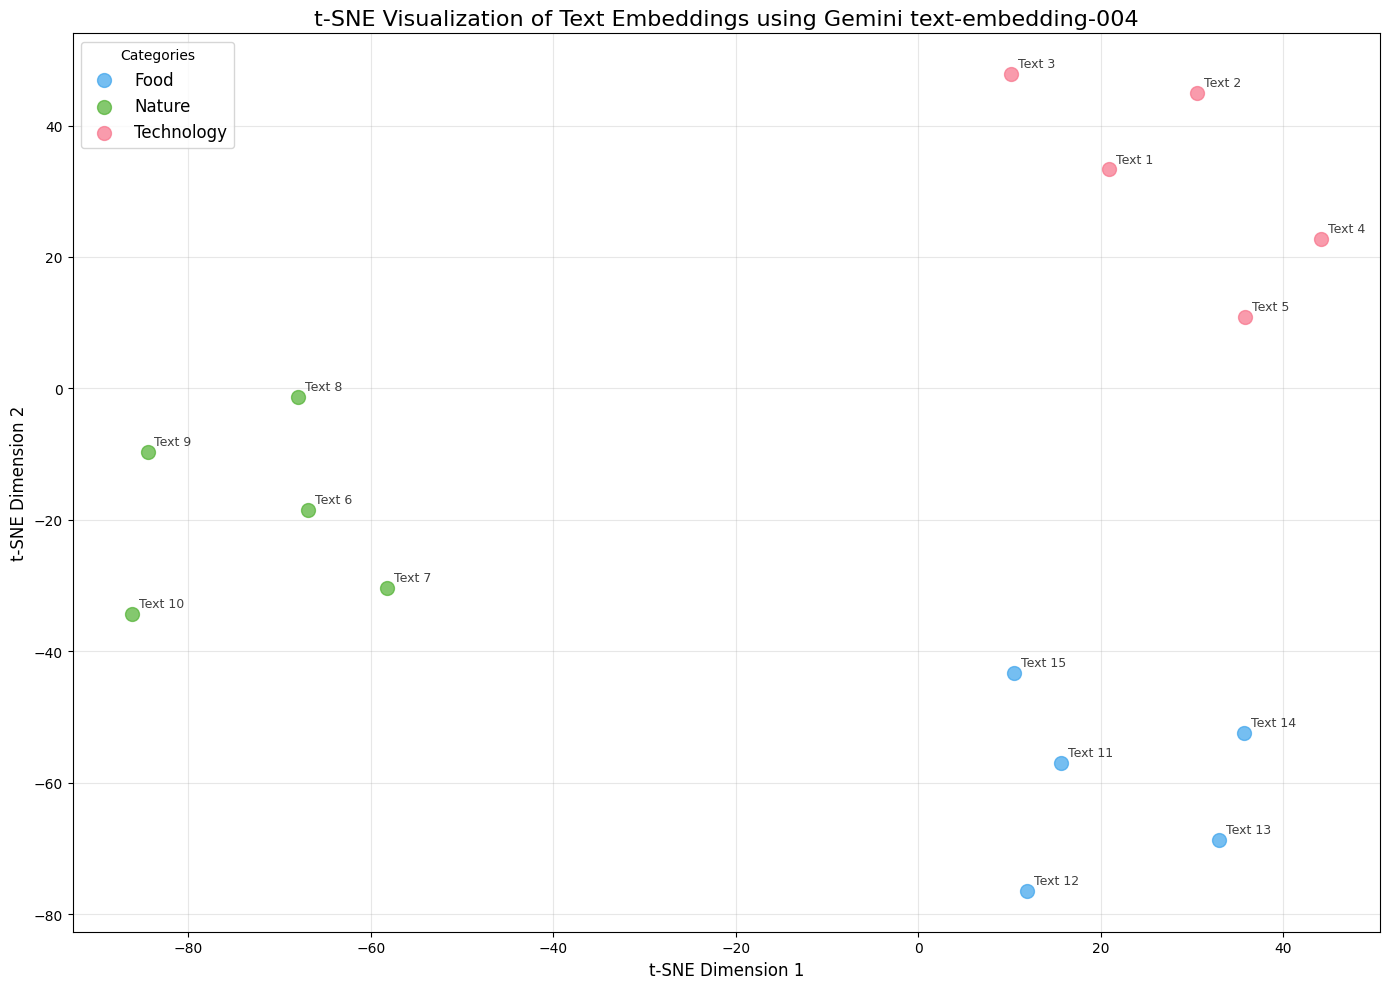

In [50]:
# Install and import t-SNE
!pip install sklearn
from sklearn.manifold import TSNE

# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, perplexity=5, random_state=42, n_iter=1000)
tsne_embeddings = tsne.fit_transform(embeddings_array)

# Add t-SNE results to the DataFrame
df["tsne_x"] = tsne_embeddings[:, 0]
df["tsne_y"] = tsne_embeddings[:, 1]

# Create visualization
plt.figure(figsize=(14, 10))

# Plot each category with different colors
for category, group in df.groupby("category"):
    plt.scatter(
        group["tsne_x"],
        group["tsne_y"],
        label=category,
        color=category_colors[category],
        s=100,
        alpha=0.7,
    )

# Add labels for each point
for i, row in df.iterrows():
    plt.annotate(
        f"Text {i + 1}",
        (row["tsne_x"], row["tsne_y"]),
        fontsize=9,
        alpha=0.75,
        xytext=(5, 5),
        textcoords="offset points",
    )

# Add title and labels
plt.title(
    "t-SNE Visualization of Text Embeddings using Gemini text-embedding-004",
    fontsize=16,
)
plt.xlabel("t-SNE Dimension 1", fontsize=12)
plt.ylabel("t-SNE Dimension 2", fontsize=12)

# Add a legend
plt.legend(fontsize=12, title="Categories")

# Add grid lines
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## Conclusion

In this notebook, we've explored text embeddings generated by Google's Gemini text-embedding-004 model. We've seen how these high-dimensional embeddings can be visualized in 2D and 3D space using dimensionality reduction techniques like PCA and t-SNE.

The visualizations help us understand how the embedding model captures semantic relationships between texts, grouping similar concepts closer together in the embedding space. This property makes text embeddings powerful for a wide range of NLP applications, from classification to semantic search.

When implementing this notebook, remember to:
1. Replace the placeholder API key with your actual Google API key
2. Customize the sample texts based on your specific use case
3. Adjust the visualization parameters to better suit your data
4. Consider experimenting with other dimensionality reduction techniques